In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
from FSC import GenerationDiscreteObs as FSC_DiscreteObs
from FSC import InferenceDiscreteObs as FSC_InferenceDiscreteObs
from FSC_DoubleGrad import InferenceDiscreteObs as FSC_DoubleGrad_InferenceDiscreteObs
import ObsModels 

In [3]:
# set matplotlib font to avenir
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'

# Finite State Controller with $M = 2$, $A = 2$, $Y = 2$

# Observations, one step

In [4]:
NStepsObs = 1
NTraj = 500
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)

In [5]:
M = 2
A = 2

np.random.seed(0)
Theta = np.random.randn(Y, M, M, A)

Psi = np.array([1, 1])

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [6]:
FSC.load_observations(observations)

In [7]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

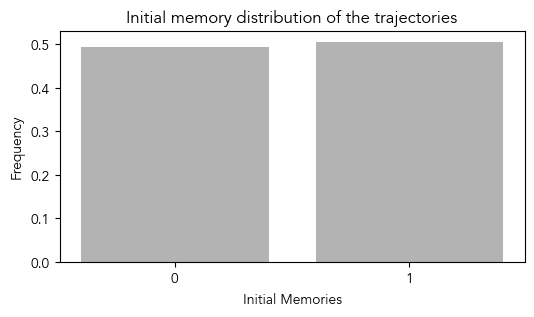

In [8]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [10]:
FSC.evaluate_nloglikelihood(trajectories[0])

0.4169199915511197

### Inference (gradient-based)

In [33]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.6199, device='mps:0', grad_fn=<SubBackward0>)

In [34]:
psi_pre_fit = FSC_tofit.psi.detach().cpu().numpy()
rho_pre_fit = FSC_tofit.rho.detach().cpu().numpy()

In [35]:
MSE = FSC_tofit.optimize_psionly(maxiter = 5000, th = 1e-15)

In [36]:
MSE

9.420554752102651e-16

### Inference (SGD)

In [20]:
FSC_SDG = FSC_DoubleGrad_InferenceDiscreteObs(M, A, Y, seed = 1234)
FSC_SDG.load_theta(Theta.astype(np.float32))
FSC_SDG.load_trajectories(trajectories)
FSC_SDG.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.1349, device='mps:0', grad_fn=<SubBackward0>)

In [21]:
psi_pre_fit_SDG = FSC_SDG.psi.detach().cpu().numpy()
rho_pre_fit_SDG = FSC_SDG.rho.detach().cpu().numpy()

In [22]:
tloss, vloss = FSC_SDG.optimize_psionly(NEpochs = 40, NBatch = 100, lr = 0.1, gamma = 0.9)

Training with 400 trajectories and validating with 100 trajectories.
Epoch 1 - Training loss: 0.7378512001037598, Validation loss: 0.703638950586319 - Learning rate: 0.1
Epoch 2 - Training loss: 0.729046859741211, Validation loss: 0.6944243063032627 - Learning rate: 0.09000000000000001
Epoch 3 - Training loss: 0.7145250129699707, Validation loss: 0.6810075579583645 - Learning rate: 0.08100000000000002
Epoch 4 - Training loss: 0.6968920516967773, Validation loss: 0.6649319723248481 - Learning rate: 0.07290000000000002
Epoch 5 - Training loss: 0.6790768051147461, Validation loss: 0.6510684940218926 - Learning rate: 0.06561000000000002
Epoch 6 - Training loss: 0.6637708759307862, Validation loss: 0.644335944056511 - Learning rate: 0.05904900000000002
Epoch 7 - Training loss: 0.6591658210754394, Validation loss: 0.6441046899557114 - Learning rate: 0.05314410000000002
Epoch 8 - Training loss: 0.6587911796569824, Validation loss: 0.6469445270299912 - Learning rate: 0.04782969000000002
Epoch 

### Comparison

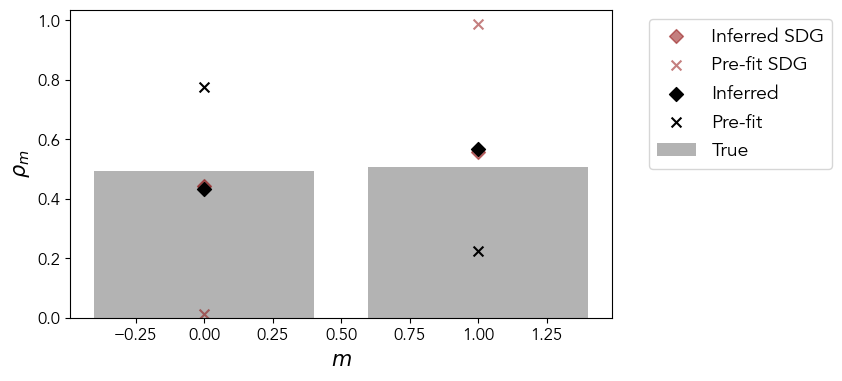

In [39]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")

ax.scatter(np.arange(M), FSC_SDG.rho.detach().cpu(), color = "darkred", marker = "D", s = 50, label = "Inferred SDG", alpha = 0.5)
ax.scatter(np.arange(M), rho_pre_fit_SDG, color = "darkred", marker = "x", s = 50, label = "Pre-fit SDG", alpha = 0.5)

ax.scatter(np.arange(M), FSC_tofit.rho.cpu(), color = "black", marker = "D", s = 50, label = "Inferred")
ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")


ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Finite State Controller with $M = 2$, $A = 2$, $Y = 5$

# Observations, one step

In [40]:
NStepsObs = 1
NTraj = 500
Y = 5
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)

In [41]:
M = 2
A = 2

np.random.seed(9)
Theta = np.random.randn(Y, M, M, A)

Psi = np.array([1.25, 1])

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 5 observations.


In [42]:
FSC.load_observations(observations)

In [43]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

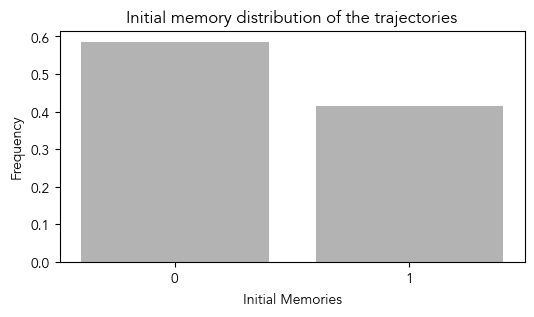

In [44]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [45]:
FSC.evaluate_nloglikelihood(trajectories[0])

0.5221538198822843

### Inference (gradient-based)

In [46]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.4661, device='mps:0', grad_fn=<SubBackward0>)

In [47]:
psi_pre_fit = FSC_tofit.psi.detach().cpu().numpy()
rho_pre_fit = FSC_tofit.rho.detach().cpu().numpy()

In [48]:
MSE = FSC_tofit.optimize_psionly(maxiter = 5000, th = 1e-15)

In [49]:
MSE

9.820925191391734e-16

### Inference (SGD)

In [50]:
FSC_SDG = FSC_DoubleGrad_InferenceDiscreteObs(M, A, Y, seed = 1234)
FSC_SDG.load_theta(Theta.astype(np.float32))
FSC_SDG.load_trajectories(trajectories)
FSC_SDG.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.6837, device='mps:0', grad_fn=<SubBackward0>)

In [51]:
psi_pre_fit_SDG = FSC_SDG.psi.detach().cpu().numpy()
rho_pre_fit_SDG = FSC_SDG.rho.detach().cpu().numpy()

In [52]:
tloss, vloss = FSC_SDG.optimize_psionly(NEpochs = 40, NBatch = 100, lr = 0.1, gamma = 0.9)

Training with 400 trajectories and validating with 100 trajectories.
Epoch 1 - Training loss: 0.7288150787353516, Validation loss: 0.6865974687039852 - Learning rate: 0.1
Epoch 2 - Training loss: 0.7235526084899903, Validation loss: 0.6826803162693977 - Learning rate: 0.09000000000000001
Epoch 3 - Training loss: 0.7151800346374513, Validation loss: 0.6770430912077426 - Learning rate: 0.08100000000000002
Epoch 4 - Training loss: 0.7052282714843751, Validation loss: 0.6702428229153157 - Learning rate: 0.07290000000000002
Epoch 5 - Training loss: 0.6911764907836915, Validation loss: 0.6637800645828247 - Learning rate: 0.06561000000000002
Epoch 6 - Training loss: 0.6824528121948242, Validation loss: 0.6592995211482048 - Learning rate: 0.05904900000000002
Epoch 7 - Training loss: 0.6759901618957519, Validation loss: 0.6580158185958862 - Learning rate: 0.05314410000000002
Epoch 8 - Training loss: 0.6720133590698242, Validation loss: 0.6585991352796554 - Learning rate: 0.04782969000000002
Epo

### Comparison

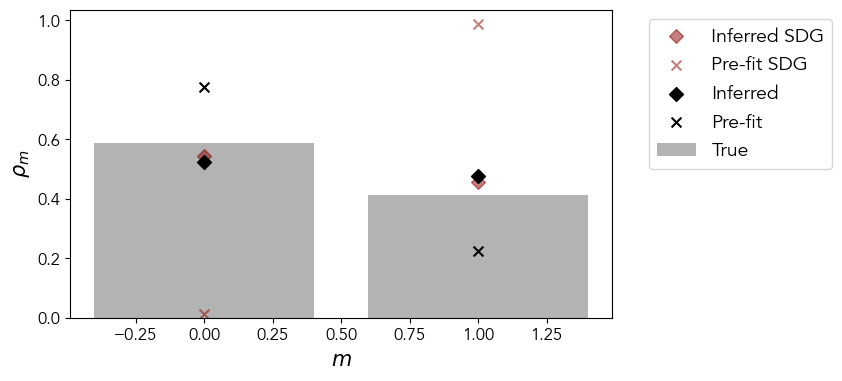

In [53]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")

ax.scatter(np.arange(M), FSC_SDG.rho.detach().cpu(), color = "darkred", marker = "D", s = 50, label = "Inferred SDG", alpha = 0.5)
ax.scatter(np.arange(M), rho_pre_fit_SDG, color = "darkred", marker = "x", s = 50, label = "Pre-fit SDG", alpha = 0.5)

ax.scatter(np.arange(M), FSC_tofit.rho.cpu(), color = "black", marker = "D", s = 50, label = "Inferred")
ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")


ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Finite State Controller with $M = 6$, $A = 2$, $Y = 2$

# Observations, one step

In [150]:
NStepsObs = 1
NTraj = 500
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)

In [151]:
M = 6
A = 2

np.random.seed(6)
Theta = np.random.randn(Y, M, M, A)

np.random.seed(9)
Psi = np.random.randn(M)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 6 memory states, 2 actions, and 2 observations.


In [152]:
FSC.load_observations(observations)

In [153]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

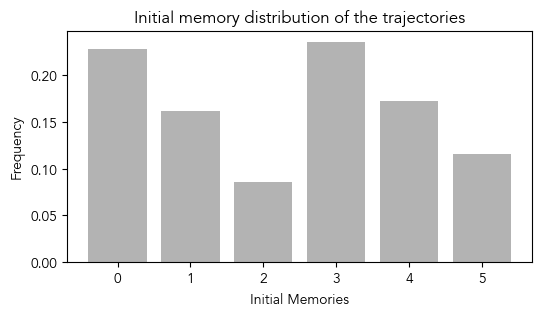

In [154]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [155]:
FSC.evaluate_nloglikelihood(trajectories[0])

0.5981997574758989

### Inference (gradient-based)

In [156]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.5254, device='mps:0', grad_fn=<SubBackward0>)

In [157]:
psi_pre_fit = FSC_tofit.psi.detach().cpu().numpy()
rho_pre_fit = FSC_tofit.rho.detach().cpu().numpy()

In [158]:
MSE = FSC_tofit.optimize_psionly(maxiter = 10000, th = 1e-15, rho0 = np.ones(M))

In [159]:
MSE, FSC_tofit.rho

(0.0, tensor([0.1950, 0.1403, 0.1442, 0.2231, 0.1195, 0.1779], device='mps:0'))

In [160]:
import numba as nb

@nb.njit
def optimize_rho(TMat, pya, rhok, maxiter, th = 1e-6):

    wVec = np.zeros((Y, A, M))
    for y in range(Y):
        for a in range(A):
            for m in range(M):
                wVec[y, a, m] = np.sum(TMat[y, m, :, a])

    for _ in range(maxiter):
        wsumexp_test_k = np.zeros((Y, A))
        
        for y in range(Y):
            for a in range(A):
                wsumexp_test_k[y, a] = np.sum(wVec[y, a] * rhok)
        
        grad = wVec * rhok / wsumexp_test_k[..., None]

        rhok_new = np.zeros(M)

        for y in range(Y):
            for a in range(A):
                rhok_new += pya[y, a] * grad[y, a]
        
        # if np.linalg.norm(rhok_new - rhok) < th:
        #     break

        rhok = rhok_new

    return rhok

In [161]:
optimize_rho(FSC_tofit.TMat.detach().cpu().numpy(), FSC_tofit.pStart_ya_emp, np.ones(M)/M, 20000)

array([0.19496627, 0.14031046, 0.14420426, 0.22310752, 0.11948549,
       0.177926  ])

### Inference (SGD)

In [162]:
FSC_SDG = FSC_DoubleGrad_InferenceDiscreteObs(M, A, Y, seed = 1234)
FSC_SDG.load_theta(Theta.astype(np.float32))
FSC_SDG.load_trajectories(trajectories)
FSC_SDG.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.8348, device='mps:0', grad_fn=<SubBackward0>)

In [163]:
psi_pre_fit_SDG = FSC_SDG.psi.detach().cpu().numpy()
rho_pre_fit_SDG = FSC_SDG.rho.detach().cpu().numpy()

In [164]:
tloss, vloss = FSC_SDG.optimize_psionly(NEpochs = 10, NBatch = 100, lr = 0.01, gamma = 0.99)

Training with 400 trajectories and validating with 100 trajectories.
Epoch 1 - Training loss: 0.7099688148498535, Validation loss: 0.7184732788801194 - Learning rate: 0.01
Epoch 2 - Training loss: 0.708406639099121, Validation loss: 0.7173652422428131 - Learning rate: 0.0099
Epoch 3 - Training loss: 0.707091064453125, Validation loss: 0.7163313883543014 - Learning rate: 0.009801
Epoch 4 - Training loss: 0.7055479049682617, Validation loss: 0.7153708365559578 - Learning rate: 0.00970299
Epoch 5 - Training loss: 0.704248218536377, Validation loss: 0.7144844603538513 - Learning rate: 0.0096059601
Epoch 6 - Training loss: 0.7031827354431153, Validation loss: 0.7136570635437965 - Learning rate: 0.009509900499
Epoch 7 - Training loss: 0.7020216369628907, Validation loss: 0.7129070997238159 - Learning rate: 0.00941480149401
Epoch 8 - Training loss: 0.7011734008789062, Validation loss: 0.7122107869386674 - Learning rate: 0.0093206534790699
Epoch 9 - Training loss: 0.7002152061462402, Validatio

### Comparison

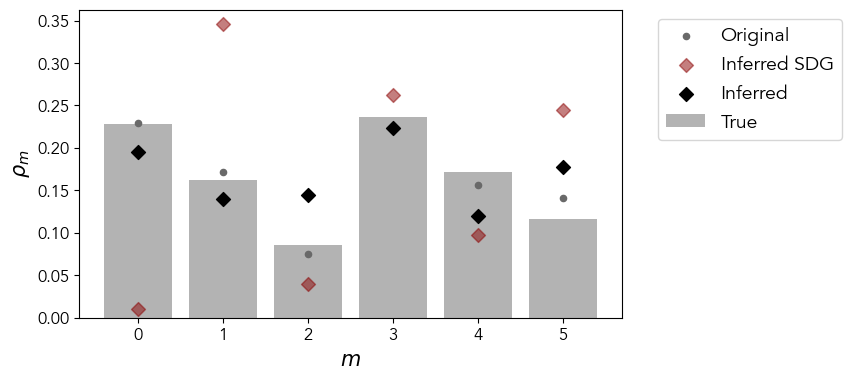

In [165]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC.rho, color = "dimgray", marker = "o", s = 20, label = "Original")

ax.scatter(np.arange(M), FSC_SDG.rho.detach().cpu(), color = "darkred", marker = "D", s = 50, label = "Inferred SDG", alpha = 0.5)
#ax.scatter(np.arange(M), rho_pre_fit_SDG, color = "darkred", marker = "x", s = 50, label = "Pre-fit SDG", alpha = 0.5)

ax.scatter(np.arange(M), FSC_tofit.rho.cpu(), color = "black", marker = "D", s = 50, label = "Inferred")
#ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [166]:
wVec = FSC_tofit.TMat.detach().cpu().numpy().sum(axis = 2).transpose(0,2,1)

-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC_SDG.rho.detach().cpu().numpy()), axis = -1)))

0.701305176615715

In [167]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC_tofit.rho.detach().cpu().numpy()), axis = -1)))

0.6881254379749298

In [168]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC.rho), axis = -1)))

0.6884107400127863

In [169]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*h), axis = -1)))

0.6883623732011349

# Finite State Controller with $M = 6$, $A = 2$, $Y = 3$

# Observations, one step

In [170]:
NStepsObs = 1
NTraj = 500
Y = 3
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)

In [171]:
M = 6
A = 2

np.random.seed(6)
Theta = np.random.randn(Y, M, M, A)

np.random.seed(9)
Psi = np.random.randn(M)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 6 memory states, 2 actions, and 3 observations.


In [172]:
FSC.load_observations(observations)

In [173]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

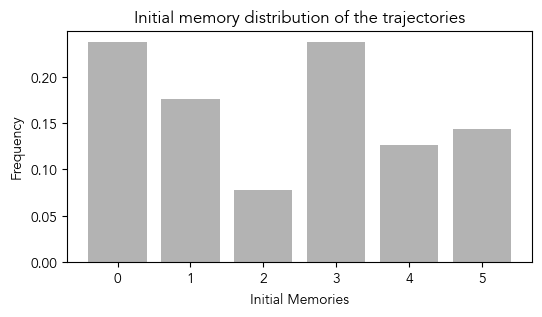

In [174]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [175]:
FSC.evaluate_nloglikelihood(trajectories[0])

0.7980645055243699

### Inference (gradient-based)

In [176]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.8948, device='mps:0', grad_fn=<SubBackward0>)

In [177]:
psi_pre_fit = FSC_tofit.psi.detach().cpu().numpy()
rho_pre_fit = FSC_tofit.rho.detach().cpu().numpy()

In [178]:
MSE = FSC_tofit.optimize_psionly(maxiter = 10000, th = 1e-15, rho0 = np.ones(M))

In [179]:
MSE, FSC_tofit.rho

(0.0, tensor([0.2172, 0.1366, 0.1138, 0.2835, 0.0785, 0.1703], device='mps:0'))

In [180]:
import numba as nb

@nb.njit
def optimize_rho(TMat, pya, rhok, maxiter, th = 1e-6):

    wVec = np.zeros((Y, A, M))
    for y in range(Y):
        for a in range(A):
            for m in range(M):
                wVec[y, a, m] = np.sum(TMat[y, m, :, a])

    for _ in range(maxiter):
        wsumexp_test_k = np.zeros((Y, A))
        
        for y in range(Y):
            for a in range(A):
                wsumexp_test_k[y, a] = np.sum(wVec[y, a] * rhok)
        
        grad = wVec * rhok / wsumexp_test_k[..., None]

        rhok_new = np.zeros(M)

        for y in range(Y):
            for a in range(A):
                rhok_new += pya[y, a] * grad[y, a]
        
        # if np.linalg.norm(rhok_new - rhok) < th:
        #     break

        rhok = rhok_new

    return rhok

In [181]:
optimize_rho(FSC_tofit.TMat.detach().cpu().numpy(), FSC_tofit.pStart_ya_emp, np.ones(M)/M, 20000)

array([0.21718132, 0.13662035, 0.11386807, 0.28352913, 0.07845216,
       0.17034898])

### Inference (SGD)

In [182]:
FSC_SDG = FSC_DoubleGrad_InferenceDiscreteObs(M, A, Y, seed = 1234)
FSC_SDG.load_theta(Theta.astype(np.float32))
FSC_SDG.load_trajectories(trajectories)
FSC_SDG.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.5691, device='mps:0', grad_fn=<SubBackward0>)

In [183]:
psi_pre_fit_SDG = FSC_SDG.psi.detach().cpu().numpy()
rho_pre_fit_SDG = FSC_SDG.rho.detach().cpu().numpy()

In [184]:
tloss, vloss = FSC_SDG.optimize_psionly(NEpochs = 10, NBatch = 100, lr = 0.01, gamma = 0.99)

Training with 400 trajectories and validating with 100 trajectories.
Epoch 1 - Training loss: 0.7013351821899414, Validation loss: 0.6944920760393143 - Learning rate: 0.01
Epoch 2 - Training loss: 0.700217685699463, Validation loss: 0.6940013402700425 - Learning rate: 0.0099
Epoch 3 - Training loss: 0.6992858123779297, Validation loss: 0.6935277634859085 - Learning rate: 0.009801
Epoch 4 - Training loss: 0.6983628654479981, Validation loss: 0.693076291680336 - Learning rate: 0.00970299
Epoch 5 - Training loss: 0.6975474548339844, Validation loss: 0.6926543146371842 - Learning rate: 0.0096059601
Epoch 6 - Training loss: 0.6966601753234863, Validation loss: 0.6922827845811844 - Learning rate: 0.009509900499
Epoch 7 - Training loss: 0.6959753799438477, Validation loss: 0.6919435518980026 - Learning rate: 0.00941480149401
Epoch 8 - Training loss: 0.6953107452392578, Validation loss: 0.6916382938623429 - Learning rate: 0.0093206534790699
Epoch 9 - Training loss: 0.6945937919616699, Validati

### Comparison

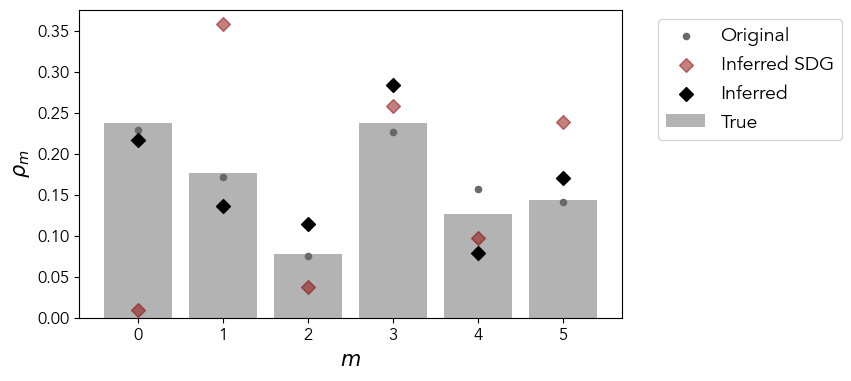

In [185]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC.rho, color = "dimgray", marker = "o", s = 20, label = "Original")

ax.scatter(np.arange(M), FSC_SDG.rho.detach().cpu(), color = "darkred", marker = "D", s = 50, label = "Inferred SDG", alpha = 0.5)
#ax.scatter(np.arange(M), rho_pre_fit_SDG, color = "darkred", marker = "x", s = 50, label = "Pre-fit SDG", alpha = 0.5)

ax.scatter(np.arange(M), FSC_tofit.rho.cpu(), color = "black", marker = "D", s = 50, label = "Inferred")
#ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [186]:
wVec = FSC_tofit.TMat.detach().cpu().numpy().sum(axis = 2).transpose(0,2,1)

-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC_SDG.rho.detach().cpu().numpy()), axis = -1)))

0.6931822967529297

In [187]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC_tofit.rho.detach().cpu().numpy()), axis = -1)))

0.6827931621074677

In [188]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC.rho), axis = -1)))

0.683383013883035

In [189]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*h), axis = -1)))

0.6831184679896867

# Finite State Controller with $M = 6$, $A = 2$, $Y = 4$

# Observations, one step

In [190]:
NStepsObs = 1
NTraj = 500
Y = 4
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)

In [191]:
M = 6
A = 2

np.random.seed(6)
Theta = np.random.randn(Y, M, M, A)

np.random.seed(9)
Psi = np.random.randn(M)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 6 memory states, 2 actions, and 4 observations.


In [192]:
FSC.load_observations(observations)

In [193]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

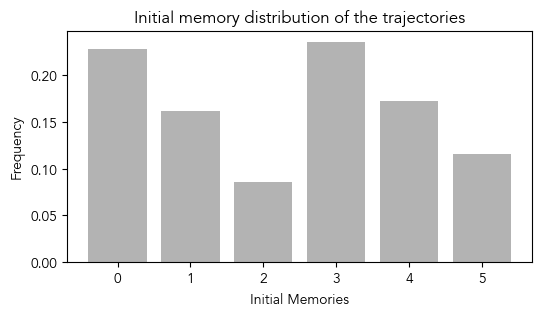

In [194]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [195]:
FSC.evaluate_nloglikelihood(trajectories[0])

0.5981997574758989

### Inference (gradient-based)

In [196]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.5254, device='mps:0', grad_fn=<SubBackward0>)

In [197]:
psi_pre_fit = FSC_tofit.psi.detach().cpu().numpy()
rho_pre_fit = FSC_tofit.rho.detach().cpu().numpy()

In [198]:
MSE = FSC_tofit.optimize_psionly(maxiter = 10000, th = 1e-15, rho0 = np.ones(M))

In [199]:
MSE, FSC_tofit.rho

(0.0,
 tensor([5.9270e-07, 2.5585e-01, 3.7239e-01, 2.8926e-01, 8.2447e-02, 5.4034e-05],
        device='mps:0'))

In [200]:
import numba as nb

@nb.njit
def optimize_rho(TMat, pya, rhok, maxiter, th = 1e-6):

    wVec = np.zeros((Y, A, M))
    for y in range(Y):
        for a in range(A):
            for m in range(M):
                wVec[y, a, m] = np.sum(TMat[y, m, :, a])

    for _ in range(maxiter):
        wsumexp_test_k = np.zeros((Y, A))
        
        for y in range(Y):
            for a in range(A):
                wsumexp_test_k[y, a] = np.sum(wVec[y, a] * rhok)
        
        grad = wVec * rhok / wsumexp_test_k[..., None]

        rhok_new = np.zeros(M)

        for y in range(Y):
            for a in range(A):
                rhok_new += pya[y, a] * grad[y, a]
        
        # if np.linalg.norm(rhok_new - rhok) < th:
        #     break

        rhok = rhok_new

    return rhok

In [201]:
optimize_rho(FSC_tofit.TMat.detach().cpu().numpy(), FSC_tofit.pStart_ya_emp, np.ones(M)/M, 20000)

array([9.50016762e-11, 2.55837558e-01, 3.72390965e-01, 2.89277925e-01,
       8.24931922e-02, 3.60248292e-07])

### Inference (SGD)

In [202]:
FSC_SDG = FSC_DoubleGrad_InferenceDiscreteObs(M, A, Y, seed = 1234)
FSC_SDG.load_theta(Theta.astype(np.float32))
FSC_SDG.load_trajectories(trajectories)
FSC_SDG.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.8348, device='mps:0', grad_fn=<SubBackward0>)

In [203]:
psi_pre_fit_SDG = FSC_SDG.psi.detach().cpu().numpy()
rho_pre_fit_SDG = FSC_SDG.rho.detach().cpu().numpy()

In [204]:
tloss, vloss = FSC_SDG.optimize_psionly(NEpochs = 10, NBatch = 100, lr = 0.01, gamma = 0.99)

Training with 400 trajectories and validating with 100 trajectories.
Epoch 1 - Training loss: 0.7000306129455567, Validation loss: 0.7022619545459747 - Learning rate: 0.01
Epoch 2 - Training loss: 0.699472427368164, Validation loss: 0.7015473288297653 - Learning rate: 0.0099
Epoch 3 - Training loss: 0.6992158889770508, Validation loss: 0.7005934935808181 - Learning rate: 0.009801
Epoch 4 - Training loss: 0.6988572311401366, Validation loss: 0.699663507938385 - Learning rate: 0.00970299
Epoch 5 - Training loss: 0.6984522247314453, Validation loss: 0.6988573956489563 - Learning rate: 0.0096059601
Epoch 6 - Training loss: 0.6981641960144043, Validation loss: 0.6980949121713639 - Learning rate: 0.009509900499
Epoch 7 - Training loss: 0.6978999137878418, Validation loss: 0.6973442634940148 - Learning rate: 0.00941480149401
Epoch 8 - Training loss: 0.6976179504394532, Validation loss: 0.6966225677728652 - Learning rate: 0.0093206534790699
Epoch 9 - Training loss: 0.6973872375488281, Validati

### Comparison

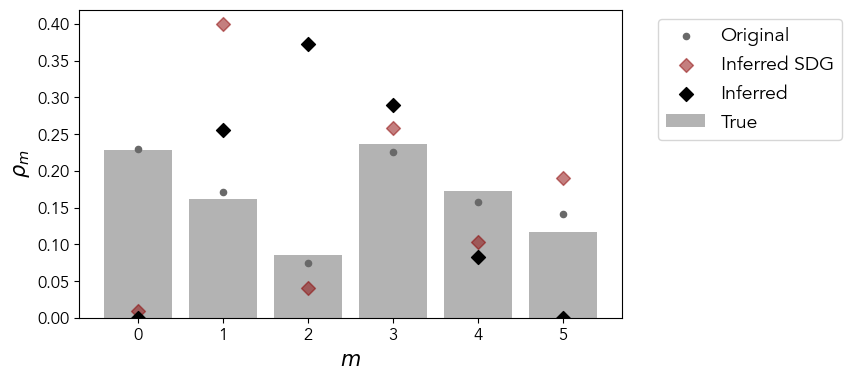

In [205]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC.rho, color = "dimgray", marker = "o", s = 20, label = "Original")

ax.scatter(np.arange(M), FSC_SDG.rho.detach().cpu(), color = "darkred", marker = "D", s = 50, label = "Inferred SDG", alpha = 0.5)
#ax.scatter(np.arange(M), rho_pre_fit_SDG, color = "darkred", marker = "x", s = 50, label = "Pre-fit SDG", alpha = 0.5)

ax.scatter(np.arange(M), FSC_tofit.rho.cpu(), color = "black", marker = "D", s = 50, label = "Inferred")
#ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [206]:
wVec = FSC_tofit.TMat.detach().cpu().numpy().sum(axis = 2).transpose(0,2,1)

-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC_SDG.rho.detach().cpu().numpy()), axis = -1)))

0.6966734697818756

In [207]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC_tofit.rho.detach().cpu().numpy()), axis = -1)))

0.6871495860815048

In [208]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC.rho), axis = -1)))

0.693372819903445

In [209]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*h), axis = -1)))

0.6927150067613064

# Finite State Controller with $M = 6$, $A = 3$, $Y = 2$

# Observations, one step

In [230]:
NStepsObs = 1
NTraj = 500
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)

In [232]:
M = 6
A = 3

np.random.seed(6)
Theta = np.random.randn(Y, M, M, A)

np.random.seed(9)
Psi = np.random.randn(M)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 6 memory states, 3 actions, and 2 observations.


In [233]:
FSC.load_observations(observations)

In [234]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

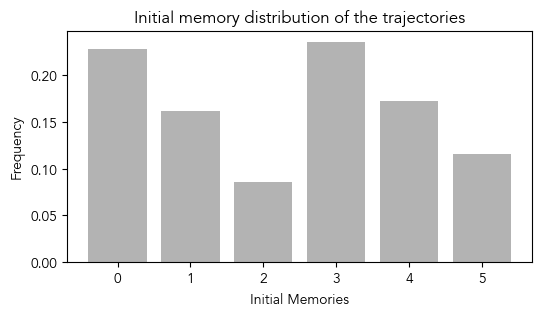

In [235]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [236]:
FSC.evaluate_nloglikelihood(trajectories[0])

1.287420719347204

### Inference (gradient-based)

In [237]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(1.3860, device='mps:0', grad_fn=<SubBackward0>)

In [238]:
psi_pre_fit = FSC_tofit.psi.detach().cpu().numpy()
rho_pre_fit = FSC_tofit.rho.detach().cpu().numpy()

In [239]:
MSE = FSC_tofit.optimize_psionly(maxiter = 10000, th = 1e-15, rho0 = np.ones(M))

In [240]:
MSE, FSC_tofit.rho

(0.0,
 tensor([1.7858e-01, 1.9674e-01, 1.1077e-01, 5.1390e-01, 7.0864e-37, 9.6660e-29],
        device='mps:0'))

In [241]:
import numba as nb

@nb.njit
def optimize_rho(TMat, pya, rhok, maxiter, th = 1e-6):

    wVec = np.zeros((Y, A, M))
    for y in range(Y):
        for a in range(A):
            for m in range(M):
                wVec[y, a, m] = np.sum(TMat[y, m, :, a])

    for _ in range(maxiter):
        wsumexp_test_k = np.zeros((Y, A))
        
        for y in range(Y):
            for a in range(A):
                wsumexp_test_k[y, a] = np.sum(wVec[y, a] * rhok)
        
        grad = wVec * rhok / wsumexp_test_k[..., None]

        rhok_new = np.zeros(M)

        for y in range(Y):
            for a in range(A):
                rhok_new += pya[y, a] * grad[y, a]
        
        # if np.linalg.norm(rhok_new - rhok) < th:
        #     break

        rhok = rhok_new

    return rhok

In [242]:
optimize_rho(FSC_tofit.TMat.detach().cpu().numpy(), FSC_tofit.pStart_ya_emp, np.ones(M)/M, 20000)

array([1.78582748e-01, 1.96743346e-01, 1.10770553e-01, 5.13903352e-01,
       6.44045062e-72, 4.94231144e-56])

### Inference (SGD)

In [243]:
FSC_SDG = FSC_DoubleGrad_InferenceDiscreteObs(M, A, Y, seed = 1234)
FSC_SDG.load_theta(Theta.astype(np.float32))
FSC_SDG.load_trajectories(trajectories)
FSC_SDG.evaluate_nloglikelihood(idx_traj = 0)

tensor(1.0145, device='mps:0', grad_fn=<SubBackward0>)

In [244]:
psi_pre_fit_SDG = FSC_SDG.psi.detach().cpu().numpy()
rho_pre_fit_SDG = FSC_SDG.rho.detach().cpu().numpy()

In [245]:
tloss, vloss = FSC_SDG.optimize_psionly(NEpochs = 10, NBatch = 100, lr = 0.01, gamma = 0.99)

Training with 400 trajectories and validating with 100 trajectories.
Epoch 1 - Training loss: 1.1054363822937012, Validation loss: 1.1075222420692443 - Learning rate: 0.01
Epoch 2 - Training loss: 1.1041492462158202, Validation loss: 1.1054256820678712 - Learning rate: 0.0099
Epoch 3 - Training loss: 1.102572269439697, Validation loss: 1.1036045062541961 - Learning rate: 0.009801
Epoch 4 - Training loss: 1.1018759536743163, Validation loss: 1.1018159425258636 - Learning rate: 0.00970299
Epoch 5 - Training loss: 1.1007003211975097, Validation loss: 1.1002676141262056 - Learning rate: 0.0096059601
Epoch 6 - Training loss: 1.0998161697387694, Validation loss: 1.0988455080986024 - Learning rate: 0.009509900499
Epoch 7 - Training loss: 1.0991077423095703, Validation loss: 1.097482922077179 - Learning rate: 0.00941480149401
Epoch 8 - Training loss: 1.0985035514831543, Validation loss: 1.0962532711029054 - Learning rate: 0.0093206534790699
Epoch 9 - Training loss: 1.0979360389709472, Validati

### Comparison

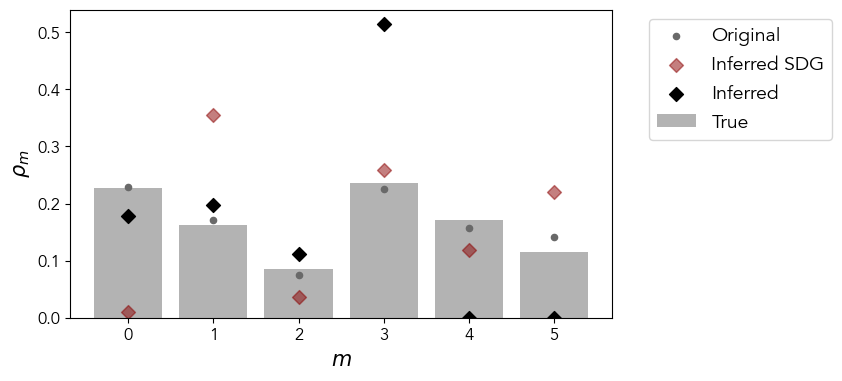

In [246]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC.rho, color = "dimgray", marker = "o", s = 20, label = "Original")

ax.scatter(np.arange(M), FSC_SDG.rho.detach().cpu(), color = "darkred", marker = "D", s = 50, label = "Inferred SDG", alpha = 0.5)
#ax.scatter(np.arange(M), rho_pre_fit_SDG, color = "darkred", marker = "x", s = 50, label = "Pre-fit SDG", alpha = 0.5)

ax.scatter(np.arange(M), FSC_tofit.rho.cpu(), color = "black", marker = "D", s = 50, label = "Inferred")
#ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [247]:
wVec = FSC_tofit.TMat.detach().cpu().numpy().sum(axis = 2).transpose(0,2,1)

-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC_SDG.rho.detach().cpu().numpy()), axis = -1)))

1.0965692651271821

In [248]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC_tofit.rho.detach().cpu().numpy()), axis = -1)))

1.088366482257843

In [249]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC.rho), axis = -1)))

1.0930030672519702

In [250]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*h), axis = -1)))

1.092971019044712

# Finite State Controller with $M = 6$, $A = 3$, $Y = 4$

# Observations, one step

In [64]:
NStepsObs = 1
NTraj = 2000
Y = 4
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)

In [65]:
M = 6
A = 3

np.random.seed(6)
Theta = np.random.randn(Y, M, M, A)

Psi = np.random.randn(M)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 6 memory states, 3 actions, and 4 observations.


In [66]:
FSC.load_observations(observations)

In [67]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

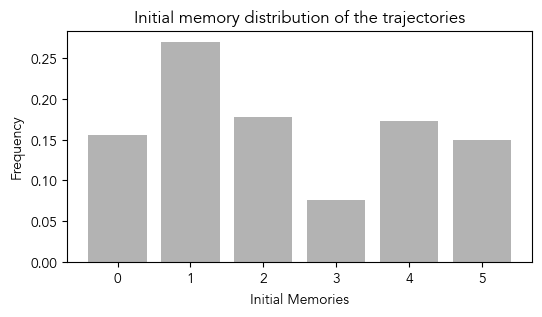

In [68]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [69]:
FSC.evaluate_nloglikelihood(trajectories[0])

1.1630620803781582

### Inference (gradient-based)

In [70]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(1.3860, device='mps:0', grad_fn=<SubBackward0>)

In [71]:
psi_pre_fit = FSC_tofit.psi.detach().cpu().numpy()
rho_pre_fit = FSC_tofit.rho.detach().cpu().numpy()

In [72]:
MSE = FSC_tofit.optimize_psionly(maxiter = 10000, th = 1e-15, rho0 = np.ones(M))

In [73]:
MSE, FSC_tofit.rho

(0.0,
 tensor([3.2145e-01, 2.3264e-01, 1.8069e-01, 2.1721e-01, 2.1181e-04, 4.7803e-02],
        device='mps:0'))

In [74]:
import numba as nb

@nb.njit
def optimize_rho(TMat, pya, rhok, maxiter, th = 1e-6):

    wVec = np.zeros((Y, A, M))
    for y in range(Y):
        for a in range(A):
            for m in range(M):
                wVec[y, a, m] = np.sum(TMat[y, m, :, a])

    for _ in range(maxiter):
        wsumexp_test_k = np.zeros((Y, A))
        
        for y in range(Y):
            for a in range(A):
                wsumexp_test_k[y, a] = np.sum(wVec[y, a] * rhok)
        
        grad = wVec * rhok / wsumexp_test_k[..., None]

        rhok_new = np.zeros(M)

        for y in range(Y):
            for a in range(A):
                rhok_new += pya[y, a] * grad[y, a]
        
        # if np.linalg.norm(rhok_new - rhok) < th:
        #     break

        rhok = rhok_new

    return rhok

In [75]:
optimize_rho(FSC_tofit.TMat.detach().cpu().numpy(), FSC_tofit.pStart_ya_emp, np.ones(M)/M, 20000)

array([3.21526154e-01, 2.32708365e-01, 1.80763597e-01, 2.17309331e-01,
       2.00881034e-06, 4.76905440e-02])

### Inference (SGD)

In [76]:
FSC_SDG = FSC_DoubleGrad_InferenceDiscreteObs(M, A, Y, seed = 1234)
FSC_SDG.load_theta(Theta.astype(np.float32))
FSC_SDG.load_trajectories(trajectories)
FSC_SDG.evaluate_nloglikelihood(idx_traj = 0)

tensor(1.0145, device='mps:0', grad_fn=<SubBackward0>)

In [77]:
psi_pre_fit_SDG = FSC_SDG.psi.detach().cpu().numpy()
rho_pre_fit_SDG = FSC_SDG.rho.detach().cpu().numpy()

In [78]:
tloss, vloss = FSC_SDG.optimize_psionly(NEpochs = 10, NBatch = 100, lr = 0.01, gamma = 0.99)

Training with 1600 trajectories and validating with 400 trajectories.
Epoch 1 - Training loss: 1.0850150156021119, Validation loss: 1.0735009399056434 - Learning rate: 0.01
Epoch 2 - Training loss: 1.083718318939209, Validation loss: 1.0719940616190433 - Learning rate: 0.0099
Epoch 3 - Training loss: 1.0829067373275758, Validation loss: 1.0710415302217007 - Learning rate: 0.009801
Epoch 4 - Training loss: 1.0822977304458619, Validation loss: 1.0705024763941764 - Learning rate: 0.00970299
Epoch 5 - Training loss: 1.081993169784546, Validation loss: 1.070275063663721 - Learning rate: 0.0096059601
Epoch 6 - Training loss: 1.081768493652344, Validation loss: 1.06987914159894 - Learning rate: 0.009509900499
Epoch 7 - Training loss: 1.08159038066864, Validation loss: 1.069632415920496 - Learning rate: 0.00941480149401
Epoch 8 - Training loss: 1.0814312410354614, Validation loss: 1.0694396212697028 - Learning rate: 0.0093206534790699
Epoch 9 - Training loss: 1.0813548898696899, Validation los

### Comparison

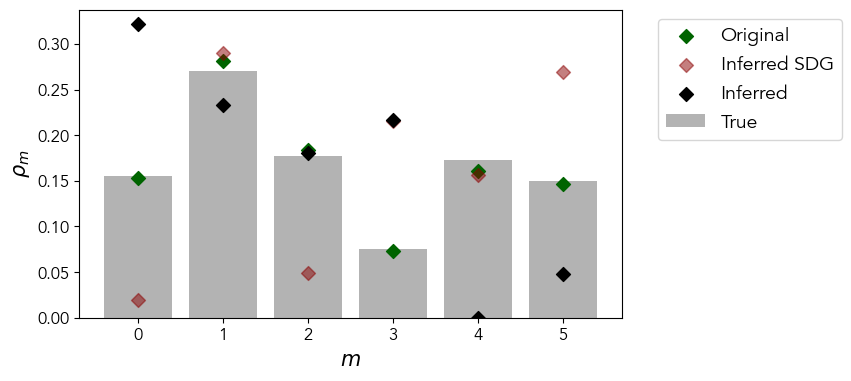

In [80]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC.rho, color = "darkgreen", marker = "D", s = 50, label = "Original")

ax.scatter(np.arange(M), FSC_SDG.rho.detach().cpu(), color = "darkred", marker = "D", s = 50, label = "Inferred SDG", alpha = 0.5)
#ax.scatter(np.arange(M), rho_pre_fit_SDG, color = "darkred", marker = "x", s = 50, label = "Pre-fit SDG", alpha = 0.5)

ax.scatter(np.arange(M), FSC_tofit.rho.cpu(), color = "black", marker = "D", s = 50, label = "Inferred")
#ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")



ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [23]:
wVec = FSC_tofit.TMat.detach().cpu().numpy().sum(axis = 2).transpose(0,2,1)

-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC_SDG.rho.detach().cpu().numpy()), axis = -1)))

1.0895509909391403

In [24]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC_tofit.rho.detach().cpu().numpy()), axis = -1)))

1.0869440196752547

In [26]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC.rho), axis = -1)))

1.0915987113264285

In [27]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*h), axis = -1)))

1.0909866637682837

## Analytic tests

In [29]:
NTraj = int(1e6)
observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 6)

In [30]:
FSC.load_observations(observations)

In [31]:
NSteps = NStepsObs
trajectories_all = FSC.generate_trajectories(NSteps)

In [32]:
ya_array = np.array([[tr['observations'][0], tr['actions'][0]]  for tr in trajectories_all])

# this is the conditional probability of the action given the observation
pAgY = np.zeros((Y, A))

for y in range(Y):
    pAgY[y] = np.histogram(ya_array[ya_array[:,0] == y, 1], bins = np.arange(-0.5, A+0.5, 1))[0]

    # normalize

    pAgY[y] = pAgY[y]/np.sum(pAgY[y])

pya = pAgY/Y

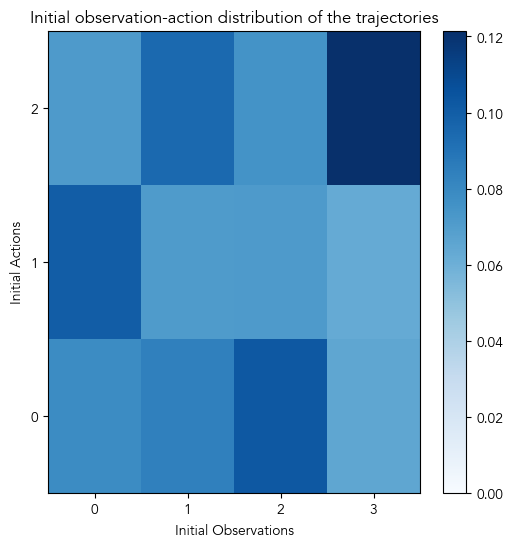

In [33]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ObsGrid, ActGrid = np.meshgrid(np.arange(Y), np.arange(A))

im = ax.pcolormesh(ObsGrid, ActGrid, pya.T, cmap = 'Blues', vmin = 0)

ax.set_xlabel('Initial Observations')
ax.set_ylabel('Initial Actions')

ax.set_xticks(np.arange(0, Y, 1))
ax.set_yticks(np.arange(0, A, 1))

ax.set_title('Initial observation-action distribution of the trajectories')

plt.colorbar(im, ax = ax)

plt.show()

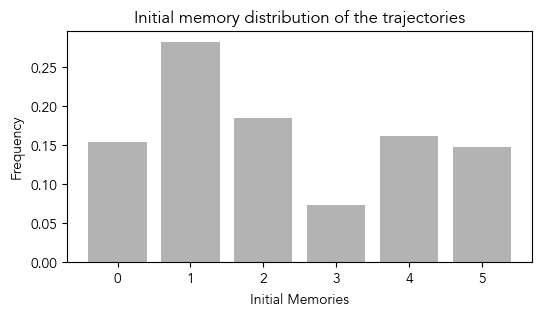

In [34]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories_all])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [35]:
wVec = FSC.TMat.sum(axis = 2)
qVec = np.exp(FSC.psi)
tempVec = np.zeros((Y, A, M))

for y in range(Y):
    for a in range(A):
        tempVec[y,a,:] = wVec[y, :, a]*qVec
        tempVec[y,a,:] = tempVec[y,a,:]/np.sum(tempVec[y,a,:])

rhoTilde = np.sum(pya[..., None]*tempVec, axis = (0,1))

print("True rho: ", FSC.rho)
print("Rho tilde: ", rhoTilde)

True rho:  [0.15339996 0.28168368 0.183567   0.0729916  0.16127062 0.14708714]
Rho tilde:  [0.15341122 0.28169493 0.18354307 0.07300151 0.16125565 0.14709363]


In [36]:
FSC_tofit_large = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit_large.load_theta(Theta.astype(np.float32))
FSC_tofit_large.load_trajectories(trajectories_all)

MSE = FSC_tofit_large.optimize_psionly(maxiter = 10000, th = 1e-15, rho0 = np.ones(M)/M)

In [37]:
FSC_tofit_large.pStart_ya_emp, pya

(array([[0.078247, 0.100104, 0.071368],
        [0.084019, 0.071085, 0.09472 ],
        [0.102812, 0.071576, 0.075341],
        [0.065626, 0.063238, 0.121864]]),
 array([[0.07833505, 0.10021664, 0.07144831],
        [0.08407819, 0.07113508, 0.09478673],
        [0.10292357, 0.07165367, 0.07542276],
        [0.06543545, 0.06305439, 0.12151016]]))

In [38]:
FSC_inferred_large = FSC_DiscreteObs(FSC_tofit_large.theta.detach().cpu().double().numpy(),
                                     FSC_tofit_large.psi.detach().cpu().double().numpy(), verbose = True)

FSC_inferred_large.rho = FSC_tofit_large.rho.detach().cpu().numpy()

Initializing FSC with 6 memory states, 3 actions, and 4 observations.


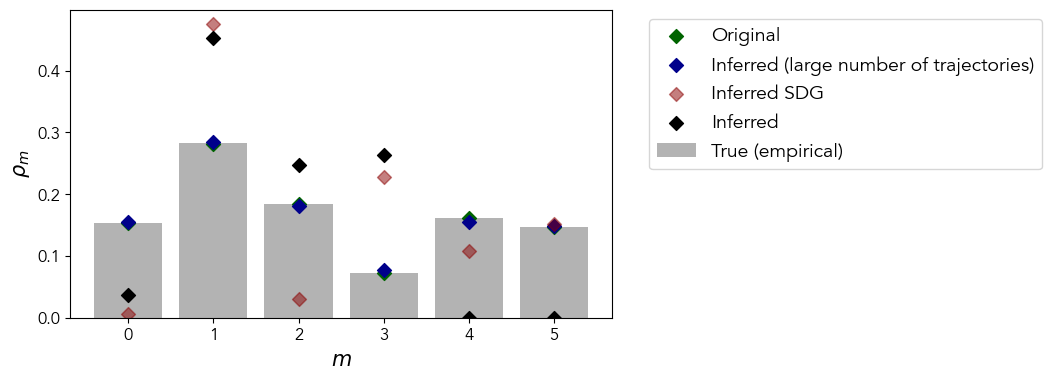

In [41]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True (empirical)")

ax.scatter(np.arange(M), FSC.rho, color = "darkgreen", marker = "D", s = 50, label = "Original")

ax.scatter(np.arange(M), FSC_inferred_large.rho, color = "darkblue", marker = "D", s = 50, label = "Inferred (large number of trajectories)")

ax.scatter(np.arange(M), FSC_SDG.rho.detach().cpu(), color = "darkred", marker = "D", s = 50, label = "Inferred SDG", alpha = 0.5)

ax.scatter(np.arange(M), FSC_tofit.rho.cpu(), color = "black", marker = "D", s = 50, label = "Inferred")


ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [43]:
wVec = FSC_tofit.TMat.detach().cpu().numpy().sum(axis = 2).transpose(0,2,1)

-np.sum(FSC_tofit_large.pStart_ya_emp*np.log(np.sum((wVec*FSC_SDG.rho.detach().cpu().numpy()), axis = -1)))

1.0831075869227649

In [45]:
-np.sum(FSC_tofit_large.pStart_ya_emp*np.log(np.sum((wVec*FSC_tofit_large.rho.detach().cpu().numpy()), axis = -1)))

1.0784299935543538

In [46]:
-np.sum(FSC_tofit_large.pStart_ya_emp*np.log(np.sum((wVec*FSC.rho), axis = -1)))

1.0784308539369434

In [47]:
-np.sum(FSC_tofit_large.pStart_ya_emp*np.log(np.sum((wVec*h), axis = -1)))

1.0784308437289762

In [162]:
FSC_inferred_large.rho

array([0.13396725, 0.28864035, 0.17110552, 0.06678097, 0.17821696,
       0.16128895], dtype=float32)

In [163]:
h

array([0.1539 , 0.2825 , 0.18125, 0.07242, 0.16119, 0.14874])

In [188]:
import scipy
import numba as nb

@nb.njit
def fun_to_min(psi, wVec, psi_k, pya):

    sumexp = np.sum(np.exp(psi))
    wsumexp_k = np.sum(wVec*np.exp(psi_k), axis = 2)

    convexified = np.sum(wVec*np.exp(psi_k)*(psi - psi_k), axis = 2)/wsumexp_k
    convexified += np.log(wsumexp_k)
    convexified = np.sum(pya*convexified)

    return np.log(sumexp) - convexified

In [189]:
# Define the gradient of your function
@nb.njit
def gradient(x, wVec, psik, pya):
    wsumexp_k = np.sum(wVec * np.exp(psik), axis=2)

    grad = wVec * np.exp(psik) / wsumexp_k[..., None]

    Y = wVec.shape[0]
    A = wVec.shape[1]

    gradvec = np.zeros(M)

    for y in range(Y):
        for a in range(A):
            gradvec += pya[y, a] * grad[y, a]

    return -gradvec + np.exp(x) / np.sum(np.exp(x))

# Implement gradient descent
@nb.njit
def gradient_descent(wVec, psik, pya, x0, initial_lr=0.5, decay_rate=0.99, max_iter=10000, tol=1e-6):
    x = x0
    learning_rate = initial_lr
    for i in range(max_iter):
        grad = gradient(x, wVec, psik, pya)
        x_new = x - learning_rate * grad
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
        learning_rate *= decay_rate  # Update the learning rate
    return x

@nb.njit
def convex_concave_optimize(NSteps, psik, wVec, pya, initial_lr=0.5, decay_rate=0.99, max_iter=10000, tol=1e-6):
    rhok_all = np.zeros((NSteps + 1, M))
    rhok_all[0] = np.exp(psik) / np.sum(np.exp(psik))

    for k in range(NSteps):
        x0 = np.zeros(M)

        res = gradient_descent(wVec, psik, pya, x0, initial_lr, decay_rate, max_iter, tol)

        psik = res

        rhok_all[k + 1] = np.exp(psik) / np.sum(np.exp(psik))

    return rhok_all

In [190]:
NSteps = 5000
wVec = FSC.TMat.sum(axis = 2).transpose(0, 2, 1)

psik = np.ones(M)

rhok_all = convex_concave_optimize(NSteps, psik, wVec, pya, initial_lr = 1, decay_rate = 1)

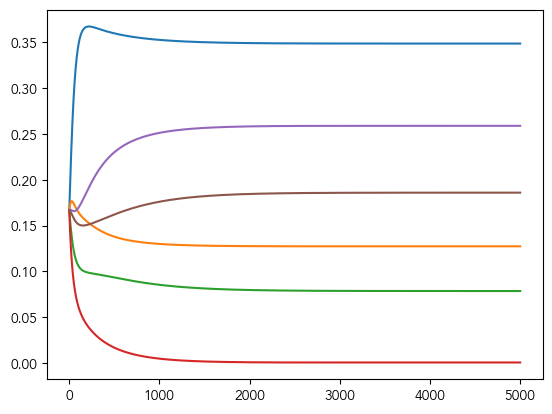

In [191]:
plt.plot(rhok_all)
plt.show()

In [192]:
h, rhok_all[-1]

(array([0.168, 0.281, 0.151, 0.086, 0.159, 0.155]),
 array([0.34875015, 0.12733459, 0.07852144, 0.00050189, 0.2589343 ,
        0.18595763]))

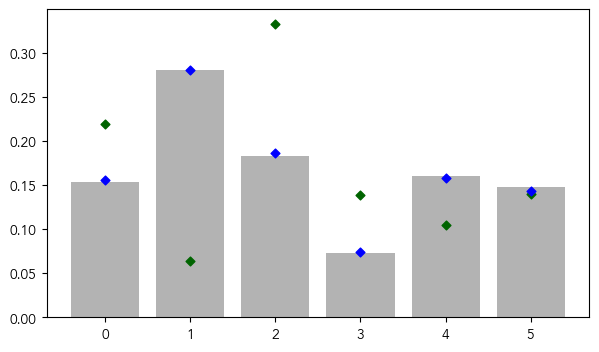

In [140]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")

ax.scatter(np.arange(M), FSC_inferred_large.rho, color = "darkgreen", marker = "D", s = 20, label = "Inferred (large number of trajectories)")
ax.scatter(np.arange(M), rhok_all[-1], color = "blue", marker = "D", s = 20, label = "Inferred (CC)")
plt.show()

In [141]:
NSteps = 1000

rhok_all = np.zeros((NSteps, M))

psik = np.ones(M)
wVec = FSC.TMat.sum(axis = 2).transpose(0, 2, 1)

for k in range(NSteps):
    x0 = np.zeros(M)

    res = scipy.optimize.minimize(fun_to_min, x0, args = (wVec, psik, pya))

    psik = res.x

    rhok_all[k] = np.exp(psik)/np.sum(np.exp(psik))

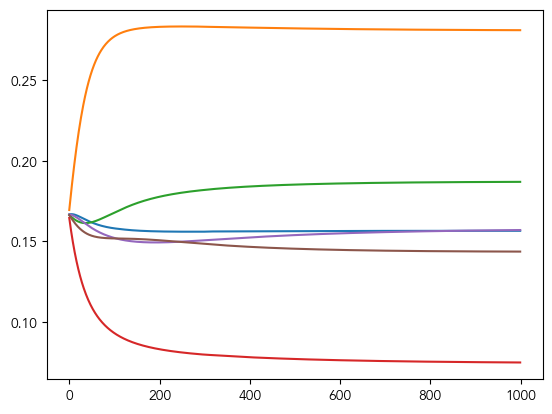

In [142]:
plt.plot(rhok_all)
plt.show()

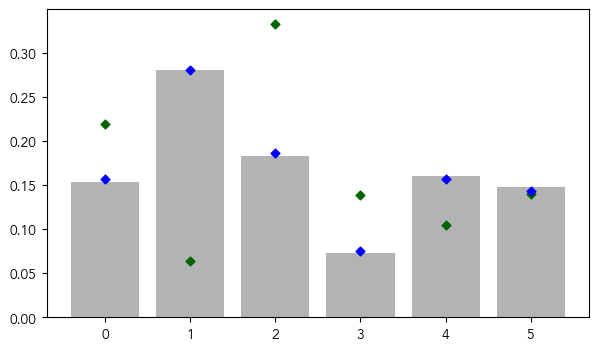

In [143]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")

ax.scatter(np.arange(M), FSC_inferred_large.rho, color = "darkgreen", marker = "D", s = 20, label = "Inferred (large number of trajectories)")
ax.scatter(np.arange(M), rhok_all[-1], color = "blue", marker = "D", s = 20, label = "Inferred (CC)")
plt.show()

In [144]:
@nb.njit
def optimize_rho(TMat, pya, rhok, maxiter, th = 1e-6):

    wVec = np.zeros((Y, A, M))
    for y in range(Y):
        for a in range(A):
            for m in range(M):
                wVec[y, a, m] = np.sum(TMat[y, m, :, a])

    for _ in range(maxiter):
        wsumexp_test_k = np.zeros((Y, A))
        
        for y in range(Y):
            for a in range(A):
                wsumexp_test_k[y, a] = np.sum(wVec[y, a] * rhok)
        
        grad = wVec * rhok / wsumexp_test_k[..., None]

        rhok_new = np.zeros(M)

        for y in range(Y):
            for a in range(A):
                rhok_new += pya[y, a] * grad[y, a]
        
        if np.linalg.norm(rhok_new - rhok) < th:
            break

        rhok = rhok_new

    return rhok

In [147]:
rhotest = np.ones(M)/M

rhotest = optimize_rho(FSC.TMat, pya, rhotest, 2000, th = 1e-16)

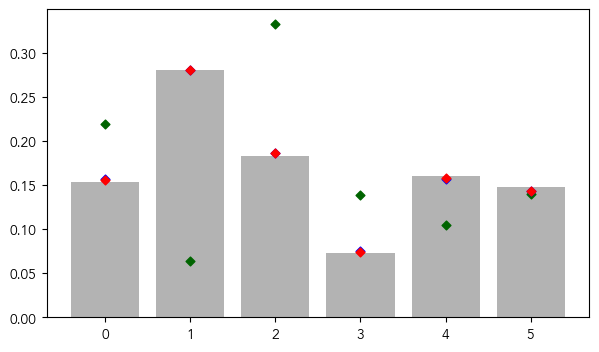

In [148]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")

ax.scatter(np.arange(M), FSC_inferred_large.rho, color = "darkgreen", marker = "D", s = 20, label = "Inferred (large number of trajectories)")
ax.scatter(np.arange(M), rhok_all[-1], color = "blue", marker = "D", s = 20, label = "Inferred (CC)")
ax.scatter(np.arange(M), rhotest, color = "red", marker = "D", s = 20, label = "Inferred (recursive)")
plt.show()

In [334]:
import fun

In [346]:
FSC.TMat[0, :, :, 0]

array([[0.01820789, 0.01012034, 0.07676143, 0.0161795 , 0.01777436,
        0.02829796],
       [0.05832058, 0.18948692, 0.07055437, 0.06308196, 0.01720357,
        0.07942623],
       [0.00529874, 0.05616675, 0.02037813, 0.01131356, 0.02535925,
        0.13009901],
       [0.01806232, 0.01595567, 0.04432547, 0.05986452, 0.04524999,
        0.03443719],
       [0.15115602, 0.01828275, 0.0335523 , 0.10395058, 0.0202608 ,
        0.01235253],
       [0.06310931, 0.0418651 , 0.03668403, 0.02778298, 0.04203594,
        0.03252538]])

In [351]:
thetak = np.ones((Y, M, M, A))

Tk = fun.softmax(thetak, axis = (2, 3))
Tk = Tk[0, :, :, 0]

for _ in range(1000):
    norm = np.sum(np.dot(Tk.T, FSC.rho))

    for mu in range(M):
        for nu in range(M):
            Tk[mu, nu] = Tk[mu, nu]*FSC.rho[mu]/norm

Tk

array([[1.92931879e-265, 1.92931879e-265, 1.92931879e-265,
        1.92931879e-265, 1.92931879e-265, 1.92931879e-265],
       [1.66666667e-001, 1.66666667e-001, 1.66666667e-001,
        1.66666667e-001, 1.66666667e-001, 1.66666667e-001],
       [1.79789900e-187, 1.79789900e-187, 1.79789900e-187,
        1.79789900e-187, 1.79789900e-187, 1.79789900e-187],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [1.03611009e-243, 1.03611009e-243, 1.03611009e-243,
        1.03611009e-243, 1.03611009e-243, 1.03611009e-243],
       [1.08360253e-283, 1.08360253e-283, 1.08360253e-283,
        1.08360253e-283, 1.08360253e-283, 1.08360253e-283]])

In [ ]:
thetak = np.ones((Y, M, M, A))

Tk = fun.softmax(thetak, axis = (2, 3))

for _ in range(1000):
    for y in range(Y):
        for a in range(A):
            Tcurr = Tk[y, :, :, a]
            norm = np.sum(np.dot(Tcurr.T, FSC.rho))

            Tk[y, :, :, a] = pya[y, a]*(Tcurr.T*FSC.rho)/norm

Tk

array([[[[9.05343818e-266, 1.16391415e-265, 8.24720217e-266],
         [8.41464732e-134, 1.08179090e-133, 7.66529757e-134],
         [8.73965298e-227, 1.12357378e-226, 7.96136050e-227],
         [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
         [6.63459618e-255, 8.52946715e-255, 6.04376536e-255],
         [6.78494840e-275, 8.72276065e-275, 6.18072826e-275]],

        [[8.41464732e-134, 1.08179090e-133, 7.66529757e-134],
         [7.82092816e-002, 1.00546210e-001, 7.12445089e-002],
         [8.12300213e-095, 1.04429686e-094, 7.39962426e-095],
         [4.45523882e-295, 5.72767538e-295, 4.05848635e-295],
         [6.16647354e-123, 7.92764655e-123, 5.61733045e-123],
         [6.30621723e-143, 8.10730168e-143, 5.74462955e-143]],

        [[8.73965298e-227, 1.12357378e-226, 7.96136050e-227],
         [8.12300213e-095, 1.04429686e-094, 7.39962426e-095],
         [8.43674334e-188, 1.08463158e-187, 7.68542587e-188],
         [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
    